In [1]:
import os
from os import path
import numpy as np
import random
import copy
import pandas as pd
import ipython_bell

from astropy.io import fits
from astropy.table import Table
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
from astropy.visualization import make_lupton_rgb
import sys

plt.style.use('dark_background')

In [2]:
#Makes 3 plots per image: source simulation, lens cutout, complete simulation
def make_graphs(name, sim_i, sim_r, sim_g, cutout_i, cutout_r, cutout_g):
    loc = plticker.MultipleLocator(base=3.75)
    fig, (ax1, ax2, ax3) = plt.subplots(figsize=(15, 4), ncols=3)

    rgb = make_lupton_rgb(sim_i, sim_r, sim_g, Q=11., stretch=40.)
    ax1.set_title('Source(s)')
    ax1.xaxis.set_ticklabels([])
    ax1.yaxis.set_ticklabels([])
    #ax1.xaxis.set_major_locator(loc)
    #ax1.yaxis.set_major_locator(loc)
    #ax1.grid(which='major', axis='both', linestyle='-')
    original = ax1.imshow(rgb, aspect='equal')#, vmin=0, vmax = 250)
    #fig.colorbar(original, ax=ax1)

    rgb = make_lupton_rgb(cutout_i, cutout_r, cutout_g, Q=11., stretch=40.)
    ax2.set_title('Lens')
    ax2.xaxis.set_ticklabels([])
    ax2.yaxis.set_ticklabels([])
    #ax2.xaxis.set_major_locator(loc)
    #ax2.yaxis.set_major_locator(loc)
    #ax2.grid(which='major', axis='both', linestyle='-')
    cutout = ax2.imshow(rgb, aspect='equal')
    #fig.colorbar(cutout, ax=ax2)
            
    rgb = make_lupton_rgb(sim_i+cutout_i, sim_r+cutout_r, sim_g+cutout_g, Q=11., stretch=40.)
    ax3.set_title('Complete Simulation')
    ax3.xaxis.set_ticklabels([])
    ax3.yaxis.set_ticklabels([])
    #ax3.xaxis.set_major_locator(loc)
    #ax3.yaxis.set_major_locator(loc)
    #ax3.grid(which='major', axis='both', linestyle='-')
    projection = ax3.imshow(rgb, aspect='equal')
    #fig.colorbar(projection, ax=ax3)
    sub_path = '/Users/jimenagonzalez/research/DSPL/Simulations-Double-Source-Gravitational-Lensing/'
    #plt.savefig(sub_path + 'Data/Sim_complete/Image' + name + '.png', bbox_inches='tight')
    plt.show()

In [3]:
# Writes fit file
def write_fit_file(name, x, datos):
    primary = fits.PrimaryHDU()
    image = fits.ImageHDU(x, name="IMAGE")
    #table = fits.TableHDU(data = datos)
    table = fits.BinTableHDU(data = datos)
    hdu_list = fits.HDUList([primary, image, table])
    hdu_list.writeto('/Users/jimenagonzalez/research/DSPL/Simulations-Double-Source-Gravitational-Lensing/Data/Sim_complete/' + name + '.fits', overwrite=True)

In [4]:
def complete_simulations(m, ids):
    directory_sim = '/Users/jimenagonzalez/research/DSPL/Simulations-Double-Source-Gravitational-Lensing/Data/Sim/'
    directory_cutouts = '/Users/jimenagonzalez/research/DSPL/Simulations-Double-Source-Gravitational-Lensing/Data/lens_cutouts/'
    end_name = ['_g.fits', '_i.fits', '_r.fits']
    x = np.zeros((1,3,46,46)) #Complete Simulations
    n = 0
    for lens_id in ids:
        path_sim_id = directory_sim + str(lens_id)
        if(n >= m):
            break
        #check that the sim id folder exist (if not continue)
        if(os.path.exists(path_sim_id) == False):
            continue
        num_sim_id = int(len(os.listdir(path_sim_id))/3) # num sim with same lens
        #loop on each simulation produced using the same lens
        for j in range(1, num_sim_id+1):
            if(n >= m):
                break
            n += 1 #number of total simulations
            path_cutout = directory_cutouts + str(lens_id) 
            path_sim = path_sim_id + '/' + str(j)
            if(os.path.exists(path_cutout + end_name[0]) == False): 
                continue
            with fits.open(path_cutout + end_name[0]) as hdul: cutout_g = hdul[0].data
            with fits.open(path_cutout + end_name[1]) as hdul: cutout_i = hdul[0].data
            with fits.open(path_cutout + end_name[2]) as hdul: cutout_r = hdul[0].data
            with fits.open(path_sim + end_name[0]) as hdul: sim_g = hdul[0].data
            with fits.open(path_sim + end_name[1]) as hdul: sim_i = hdul[0].data
            with fits.open(path_sim + end_name[2]) as hdul: sim_r = hdul[0].data
            
            ele_sim = np.array([cutout_g + sim_g, cutout_r + sim_r, cutout_i + sim_i])
            ele_sim = np.rot90(ele_sim, k=random.randint(0, 4), axes=(1, 2))
            if(random.randint(0, 1) == 1):
                ele_sim = np.flip(ele_sim, 2)
            x = np.append(x, [ele_sim], axis = 0)
    x = np.delete(x, 0, axis = 0)
    return(x)

In [5]:
#19712 lens cutouts
ids = pd.read_csv('/Users/jimenagonzalez/research/DSPL/Simulations-Double-Source-Gravitational-Lensing/Data/all_data_sim.csv')['COADD_OBJECT_ID'].sample(frac = 1)
x = complete_simulations(34, ids)
print(len(x))

34


In [6]:
#generating table:

datos = np.zeros((1,4))
ele_sim = np.array([1,2,3,4])

for i in range(11):
    datos = np.append(datos, np.ones((1,4)), axis = 0)
    datos = np.append(datos, [ele_sim], axis = 0)  
    datos = np.append(datos, np.zeros((1,4)), axis = 0)

#print(datos)

names = ['a', 'b', 'c', 'd']
datos = Table(data = datos, names = names)
datos

a,b,c,d
float64,float64,float64,float64
0.0,0.0,0.0,0.0
1.0,1.0,1.0,1.0
1.0,2.0,3.0,4.0
0.0,0.0,0.0,0.0
1.0,1.0,1.0,1.0
1.0,2.0,3.0,4.0
0.0,0.0,0.0,0.0
1.0,1.0,1.0,1.0
1.0,2.0,3.0,4.0


In [7]:
name_file = 'other' #'other'

In [8]:
print(x.shape)
write_fit_file(name_file, x, datos)

(34, 3, 46, 46)


In [9]:
filename = '/Users/jimenagonzalez/research/DSPL/Simulations-Double-Source-Gravitational-Lensing/Data/Sim_complete/'
filename = filename + 'other.fits'
hdul = fits.open(filename)
hdul.info()
images = hdul[1].data.astype(np.float32)
datos = hdul[2].data
hdul.close()

Filename: /Users/jimenagonzalez/research/DSPL/Simulations-Double-Source-Gravitational-Lensing/Data/Sim_complete/other.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  IMAGE         1 ImageHDU        10   (46, 46, 3, 34)   float64   
  2                1 BinTableHDU     16   34R x 4C   [D, D, D, D]   


In [10]:
print(images.shape)
l1, l2 = np.zeros(int(len(x)/2), dtype = np.int64), np.ones(int(len(x)/2), dtype = np.int64)
labels = np.concatenate((l1, l2))
print(labels.shape)

(34, 3, 46, 46)
(34,)


In [11]:
print(datos)
df = pd.DataFrame(datos)
print(df.shape)

[(0., 0., 0., 0.) (1., 1., 1., 1.) (1., 2., 3., 4.) (0., 0., 0., 0.)
 (1., 1., 1., 1.) (1., 2., 3., 4.) (0., 0., 0., 0.) (1., 1., 1., 1.)
 (1., 2., 3., 4.) (0., 0., 0., 0.) (1., 1., 1., 1.) (1., 2., 3., 4.)
 (0., 0., 0., 0.) (1., 1., 1., 1.) (1., 2., 3., 4.) (0., 0., 0., 0.)
 (1., 1., 1., 1.) (1., 2., 3., 4.) (0., 0., 0., 0.) (1., 1., 1., 1.)
 (1., 2., 3., 4.) (0., 0., 0., 0.) (1., 1., 1., 1.) (1., 2., 3., 4.)
 (0., 0., 0., 0.) (1., 1., 1., 1.) (1., 2., 3., 4.) (0., 0., 0., 0.)
 (1., 1., 1., 1.) (1., 2., 3., 4.) (0., 0., 0., 0.) (1., 1., 1., 1.)
 (1., 2., 3., 4.) (0., 0., 0., 0.)]
(34, 4)


In [12]:
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils.multiclass import unique_labels
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [13]:
class ImageDataset(Dataset):
    """Dataset of Images and Labels"""

    def __init__(self, images, labels, transform=None):
        """
        Create a PyTorch dataset from an array of images
		and an array of labels
        """
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image = self.images[idx]
        label = np.array(self.labels[idx])
        
        sample = {'image': image, 'label': label}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [14]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors"""

    def __call__(self, sample):
        image, label = sample['image'], sample['label']
		
		# I like to add any scaling functions here, so uncomment if desired
		#image = (image - np.min(image, axis=(-1,-2))[:,:,np.newaxis,np.newaxis]) / np.max(image - np.min(image, axis=(-1,-2))[:,:,np.newaxis,np.newaxis], axis=(-1,-2))[:,:,np.newaxis,np.newaxis]

        return {'image': torch.from_numpy(image).float(),
                'label': torch.from_numpy(label)}

In [15]:
def make_train_test_datasets(images, data, labels, test_size=0.2, transform=ToTensor()):
    """
	Make training and testing datasets
	
	Args:
	    images: 4D array of all images
        labels: 1D array of the labels for each image
        test_size: the fraction of the images to use as the test dataset
		transform: the PyTorch transformation to apply to the data
		
	Returns
	    train_dataset: An instance of the ImageDataset Class for training
		test_dataset: An instance of the ImageDataset Class for testing
	"""

    # Shuffle and split data
    y = labels
    train_images, test_images, train_labels, test_labels = train_test_split(
        images, labels, test_size=test_size, random_state=8, stratify=y)
    
    train_data, test_data, ttrain_labels, ttest_labels = train_test_split(
        data, labels, test_size=test_size, random_state=8, stratify=y)
    
    print(train_labels)
    print(ttrain_labels)
    
    # Create a PyTorch Dataset
    return (ImageDataset(train_images, train_labels, transform=transform),
            ImageDataset(test_images, test_labels, transform=transform), train_data, test_data)

In [16]:
class CNN(nn.Module):
    """
    Convolutional Neural Network for multiband data. Note that you
    will need to update the number of in_features for self.fc3.
    """
    def __init__(self, in_channels, num_classes):
        """
		Args:
		    in_channels: number of bands (gri = 3, griz=4)
			num_classes: number of unique labels in your dataset
		"""
        super(CNN, self).__init__()
        
        #Network Components
        self.conv1 = nn.Conv2d(in_channels=in_channels, 
                               out_channels=48, 
                               kernel_size=15, 
                               stride=3,
                               padding=2)

        self.conv2 = nn.Conv2d(in_channels=48, 
                               out_channels=96,
                               kernel_size=5, 
                               stride=1,
                               padding=2)
        
        self.dropout1 = nn.Dropout2d(0.25)
        
        self.dropout2 = nn.Dropout2d(0.5)
        
        self.fc1 = nn.Linear(in_features=3456, 
                             out_features=408)

        self.fc2 = nn.Linear(in_features=408, 
                             out_features=25)

        self.fc3 = nn.Linear(in_features=25, 
                             out_features=num_classes)


    def forward(self, x):
        #Network Flow
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        output = F.log_softmax(x, dim=1)
        return output

    def init_weights(self, m):
        if (type(m) == nn.Linear or type(m) == nn.Conv2d):
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)

In [17]:
def train_cnn(
    cnn, 
    train_dataloader, 
    train_dataset=None,
    test_dataset=None,
    validation_size=None, 
    monitor=False,
    number_of_training_epochs=10,
    learning_rate=0.0001):
	
    """
    Train a CNN and output performance if desired

    Args:
        cnn: an instance of the CNN class
        train_dataloader: a PyTorch DataLoader for the training dataset
        train_dataset: an instance of the ImageDataset class for training
        test_dataset: an instance of the ImageDataset class for testing
        validation_size: the number of images to use for monitoring
            - large numbers will slow down training. ~100 is good.
        monitor: set to True if you want status updates on training
        number_of_training_epochs: number of times to go through the dataset
        learning_rate: multiplicative factor for updating network weights
            - small learning_rate will mean slow training
            - large learning_rate will train fast, but you may miss the best weights
            - ~0.001 is a good starting point
    """
    if not monitor and (train_dataset is None or test_dataset is None):
        raise ValueError("Must pass training and testing datasets for monitoring")
    
    if validation_size is None:
        validation_size=len(test_dataset)
    loss_function = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(cnn.parameters(), lr=learning_rate)
    
    losses, train_acc, validation_acc = [], [], []

    for epoch in range(number_of_training_epochs):
        sys.stdout.write("\rEpoch {0}\r".format(epoch + 1))
        sys.stdout.flush()

        for i_batch, sample_batched in enumerate(train_dataloader):

            #Clear out all existing gradients on the loss surface to reevaluate for this step
            optimizer.zero_grad()

            #Get the CNN's current prediction of the training data
            output = cnn(sample_batched['image'])

            #Calculate the loss by comparing the prediction to the truth
            loss = loss_function(output, sample_batched['label']) 

            #Evaluate all gradients along the loss surface using back propagation
            loss.backward()

            #Based on the gradients, take the optimal step in the weight space
            optimizer.step()

            #Performance monitoring if desired
            if monitor:
                if i_batch % 200 == 0: #before batch 200
                    train_output = cnn(train_dataset[0:validation_size]['image'])
                    validation_output = cnn(test_dataset[0:validation_size]['image'])

                    train_predictions = torch.max(train_output, 1)[1].data.numpy()
                    validation_predictions = torch.max(validation_output, 1)[1].data.numpy()

                    train_accuracy = np.sum(train_predictions == train_dataset[0:validation_size]['label'].numpy()) / validation_size
                    validation_accuracy = np.sum(validation_predictions == test_dataset[0:validation_size]['label'].numpy()) / validation_size

                    print("Epoch: {0} Batch: {1}  | Training Accuracy: {2:.3f} -- Validation Accuracy: {3:.3f} -- Loss: {4:.3f}".format(epoch + 1, i_batch + 1, train_accuracy, validation_accuracy, loss.data.numpy()))

                    losses.append(loss.data.numpy())
                    train_acc.append(train_accuracy)
                    validation_acc.append(validation_accuracy)
   
    setattr(cnn, 'losses', losses)
    setattr(cnn, 'train_acc', train_acc)
    setattr(cnn, 'validation_acc', validation_acc)

    return cnn

In [18]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title='',
                          cmap=plt.cm.Blues, name = 'generic'):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots(figsize=(5,3), dpi=120)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    
    ax.set_xticks(np.arange(cm.shape[1]))
    ax.set_yticks(np.arange(cm.shape[0]))
    ax.set_xticklabels(classes, fontsize=12)
    ax.set_yticklabels(classes, fontsize=12)
    ax.set_xlabel('Predicted Class', fontsize=14)
    ax.set_ylabel('True Class', fontsize=14)

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black", fontsize=12)
    fig.tight_layout()
    plt.show()
    return

In [19]:
def plot_performance(cnn):
    x = np.linspace(1,len(cnn.losses),len(cnn.losses))
    fig, ax1 = plt.subplots(figsize=(12, 7), ncols=1)
    ax1.set_title('Performance')
    ax1.set_xlabel('Epoch')
    ax1.plot(x, cnn.losses, 'wo', label = 'Loss')
    ax1.plot(x, cnn.train_acc, 'ro', label = 'Training Accuracy')
    ax1.plot(x, cnn.validation_acc, 'go', label = 'Validation Accuracy')
    ax1.legend()
    plt.xlim([1.5, len(cnn.losses) + 0.5])
    plt.ylim([0, 2])
    plt.show(block=True)#'Performance_' + name +'.png', bbox_inches='tight')


In [20]:
print(images.shape, datos.shape)
train_dataset, test_dataset, train_data, test_data = make_train_test_datasets(images, datos, labels)

print(test_dataset.labels)

(34, 3, 46, 46) (34,)
[1 1 1 0 1 0 0 1 1 1 1 0 0 0 1 0 0 0 1 1 0 1 1 0 0 0 0]
[1 1 1 0 1 0 0 1 1 1 1 0 0 0 1 0 0 0 1 1 0 1 1 0 0 0 0]
[0 0 1 0 1 1 1]


In [21]:
df = pd.DataFrame(test_data)
df

,a,b,c,d
0,1.0,2.0,3.0,4.0
1,1.0,1.0,1.0,1.0
2,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0
4,1.0,2.0,3.0,4.0
5,1.0,1.0,1.0,1.0
6,1.0,1.0,1.0,1.0


In [22]:
# Make a DataLoader to train the network
train_dataloader = DataLoader(train_dataset, batch_size=20, shuffle=True, num_workers=4) # batch_size = 20

# Make a CNN
cnn = CNN(
	in_channels=np.shape(images)[1], 
	num_classes=len(np.unique(labels)))

#Initialize weights
cnn.apply(cnn.init_weights)

CNN(
  (conv1): Conv2d(3, 48, kernel_size=(15, 15), stride=(3, 3), padding=(2, 2))
  (conv2): Conv2d(48, 96, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (dropout2): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=3456, out_features=408, bias=True)
  (fc2): Linear(in_features=408, out_features=25, bias=True)
  (fc3): Linear(in_features=25, out_features=2, bias=True)
)

In [23]:
# Train the CNN
cnn = train_cnn(cnn, 
				train_dataloader, 
				train_dataset=train_dataset,
				test_dataset=test_dataset,
				validation_size=200, #100
				number_of_training_epochs=10, #150
				monitor=True)

Epoch: 1 Batch: 1  | Training Accuracy: 0.060 -- Validation Accuracy: 0.020 -- Loss: 8.895
Epoch: 2 Batch: 1  | Training Accuracy: 0.080 -- Validation Accuracy: 0.020 -- Loss: 7.963
Epoch: 3 Batch: 1  | Training Accuracy: 0.070 -- Validation Accuracy: 0.010 -- Loss: 5.447
Epoch: 4 Batch: 1  | Training Accuracy: 0.060 -- Validation Accuracy: 0.015 -- Loss: 0.373
Epoch: 5 Batch: 1  | Training Accuracy: 0.065 -- Validation Accuracy: 0.015 -- Loss: 8.053
Epoch: 6 Batch: 1  | Training Accuracy: 0.080 -- Validation Accuracy: 0.010 -- Loss: 6.574
Epoch: 7 Batch: 1  | Training Accuracy: 0.085 -- Validation Accuracy: 0.015 -- Loss: 2.819
Epoch: 8 Batch: 1  | Training Accuracy: 0.055 -- Validation Accuracy: 0.015 -- Loss: 4.773
Epoch: 9 Batch: 1  | Training Accuracy: 0.065 -- Validation Accuracy: 0.030 -- Loss: 7.624
Epoch: 10 Batch: 1  | Training Accuracy: 0.060 -- Validation Accuracy: 0.020 -- Loss: 2.769


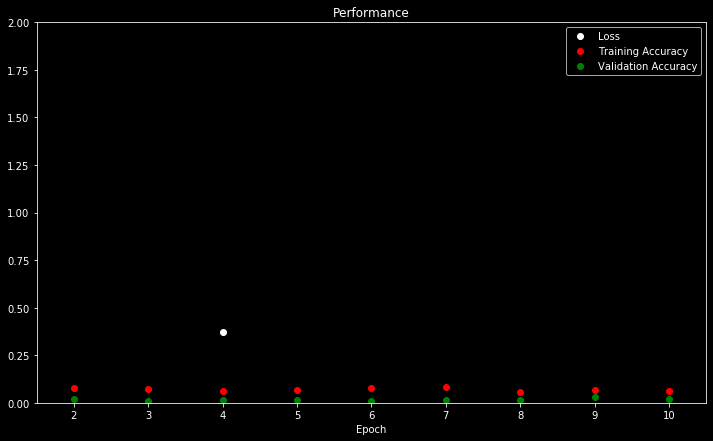

In [24]:
plot_performance(cnn)

In [25]:
# Use the CNN to classify your whole test dataset
cnn.eval()

non_binary_predictions = cnn(test_dataset[:]['image'])

test_predictions = torch.max(cnn(test_dataset[:]['image']), 1)[1].data.numpy()  
test_labels = test_dataset[:]['label'].data.numpy()

In [26]:
# I have test_predictions, test_labels, test_dataset and test_data (df)
print(test_predictions)
print(test_labels)
print(test_dataset.images.shape)
print(df)

[0 0 0 1 0 1 1]
[0 0 1 0 1 1 1]
(7, 3, 46, 46)
     a    b    c    d
0  1.0  2.0  3.0  4.0
1  1.0  1.0  1.0  1.0
2  0.0  0.0  0.0  0.0
3  0.0  0.0  0.0  0.0
4  1.0  2.0  3.0  4.0
5  1.0  1.0  1.0  1.0
6  1.0  1.0  1.0  1.0


In [27]:
#get indices of test dataset where the label is wrong predicted
indices = []
for i in range(len(test_labels)):
    if(test_predictions[i] != test_labels[i]):
        indices.append(i)

In [28]:
print(indices)

[2, 3, 4]


In [29]:
test_data[indices]

FITS_rec([(0., 0., 0., 0.), (0., 0., 0., 0.), (1., 2., 3., 4.)],
         dtype=(numpy.record, [('a', '>f8'), ('b', '>f8'), ('c', '>f8'), ('d', '>f8')]))

In [30]:
df

,a,b,c,d
0,1.0,2.0,3.0,4.0
1,1.0,1.0,1.0,1.0
2,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0
4,1.0,2.0,3.0,4.0
5,1.0,1.0,1.0,1.0
6,1.0,1.0,1.0,1.0


In [42]:
df.loc[0, : ]
#df.iloc[['1', '0'], : ]
#dfObj.iloc[[2 ,0 ] , : ]

a    1.0
b    2.0
c    3.0
d    4.0
Name: 0, dtype: float64

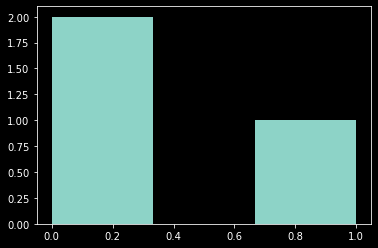

In [46]:
wpredic = test_data[indices]
wpredic['a']

plt.figure()
plt.hist(wpredic['a'], 3)
plt.show()